#  IA para Redes de Suministro 

👤 **Autor:** John Leonardo Vargas Mesa  
🔗 [LinkedIn](https://www.linkedin.com/in/leonardovargas/) | [GitHub](https://github.com/LeStark)  

## 📂 Repositorio en GitHub  
- 📓 **Notebooks:** [Acceder aquí](https://github.com/LeStark/Cursos/tree/main/02%20-%20IA4SC)  
- 📑 **Data sets:** [Acceder aquí](https://github.com/LeStark/Cursos/tree/main/00%20-%20Data/02%20-%20SC)  
---

# 📗 Notebook 6 – Uso de algoritmos de *Machine Learning* para la predicción de demanda

Este notebook desarrolla un proceso completo de **predicción de demanda semanal** utilizando algoritmos de *Machine Learning* aplicados a series temporales.  
El objetivo es mostrar cómo transformar datos históricos de ventas en un conjunto de entrenamiento adecuado para modelos predictivos capaces de anticipar la demanda futura por tienda y producto.

## 🧩 **Contenido del Notebook**

1. **Exploración y Análisis de Datos (EDA):**  
   Se inicia con la carga y revisión de un dataset de ventas históricas que contiene las columnas `date`, `store`, `item` y `sales`.  
   Se realizan análisis exploratorios para comprender el rango temporal, la distribución de ventas y el número de tiendas y productos.

2. **Conversión a Series Semanales:**  
   Los datos diarios se agrupan por semana mediante `resample('W')`, manteniendo la desagregación por tienda y producto.  
   Se añaden las columnas `year` y `week` para estructurar temporalmente la información.

3. **Descomposición de la Serie Temporal:**  
   Se analiza la estructura interna de la demanda separando componentes de tendencia y estacionalidad mediante `seasonal_decompose`.  
   Esto permite identificar patrones de crecimiento o fluctuación a lo largo del tiempo.

4. **Creación de Variables Temporales Cíclicas:**  
   Se generan variables `sin_week` y `cos_week` para representar el carácter **periódico** de las semanas del año.  
   Estas variables ayudan al modelo a captar la naturaleza cíclica del tiempo sin rupturas entre la semana 52 y la semana 1.

5. **Ingeniería de Características (Feature Engineering):**  
   - **Rezagos (lags):** se crean variables como `sales_lag_1`, `sales_lag_2`, `sales_lag_4`, `sales_lag_8`, `sales_lag_12` que representan ventas pasadas.  
   - **Ventanas móviles (rolling):** se calculan medias y desviaciones estándar sobre 4 y 8 semanas (`rolling_mean_4`, `rolling_std_8`) para capturar tendencias locales.

6. **División Temporal de Datos:**  
   En lugar de un `train_test_split` aleatorio, se separan los datos **por año**, entrenando con el histórico (hasta 2016) y evaluando con 2017, para preservar la secuencia temporal.

7. **Comparación de Modelos de Regresión:**  
   Se entrenan y comparan distintos modelos:
   - **Regresión Lineal**  
   - **Random Forest**  
   - **Gradient Boosting**  
   - **XGBoost**  
   Se evalúan mediante **RMSE** y **R²**, identificando cuál logra la mejor capacidad predictiva.

8. **Predicción Recursiva de la Demanda 2018:**  
   Se genera un conjunto base para el año 2018 con todas las combinaciones de tienda–producto–semana, y se aplican las predicciones semana a semana.  
   Tras cada predicción, se recalculan las variables de rezago para incorporar la información más reciente (*forecasting recursivo*).

9. **Visualización de Resultados:**  
   Se grafican las ventas históricas y las predicciones, diferenciando los periodos observados y pronosticados (por ejemplo, 2018 en color rojo).  
   También se incluye una versión interactiva para explorar el pronóstico por tienda y producto.

## 🎯 **Objetivo de Aprendizaje**

Al finalizar el notebook, el estudiante será capaz de:
- Comprender la naturaleza temporal y dependiente de los datos de demanda.  
- Aplicar ingeniería de características que preserve la secuencia temporal.  
- Entrenar y comparar modelos de regresión sobre series temporales.  
- Implementar un esquema de pronóstico autoregresivo para proyectar periodos futuros.


## 🧾 **Herramientas Utilizadas**
- **Python / Pandas / NumPy:** manejo y transformación de datos  
- **Matplotlib / Seaborn:** análisis visual  
- **scikit-learn:** modelado, evaluación y métricas  
- **XGBoost:** modelo avanzado de boosting  
- **statsmodels:** descomposición de series temporales  

*Este notebook sirve como introducción práctica al uso de modelos de Machine Learning en series temporales de demanda, mostrando cómo combinar técnicas estadísticas, ingeniería de variables y modelos predictivos para anticipar el comportamiento futuro de ventas.*


In [ ]:
# ===============================================
#  Importación de librerías
# ===============================================

# --- Librerías básicas ---
import numpy as np
import pandas as pd

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modelado y evaluación ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor



##  Descripción de la Celda de Datos

Esta tabla representa un conjunto de datos de ventas diarias en una tienda específica. Cada fila corresponde a una transacción registrada en un día determinado.

### Columnas

- **date**: Fecha de la transacción en formato `YYYY-MM-DD`.
- **store**: Identificador de la tienda. En este caso, todas las transacciones provienen de la tienda `1`.
- **item**: Identificador del producto vendido. Aquí, todas las filas corresponden al producto `1`.
- **sales**: Número de unidades vendidas en ese día.

### Datos Registrados

| date       | store | item | sales |
|------------|-------|------|-------|
| 2013-01-01 | 1     | 1    | 13    |
| 2013-01-02 | 1     | 1    | 11    |
| 2013-01-03 | 1     | 1    | 14    |
| 2013-01-04 | 1     | 1    | 13    |
| 2013-01-05 | 1     | 1    | 10    |

### Observaciones

- El producto `1` fue vendido exclusivamente en la tienda `1` durante los primeros cinco días de enero de 2013.
- Las ventas fluctúan ligeramente entre los días, con un máximo de `14` unidades el 3 de enero y un mínimo de `10` el 5 de enero.

Este tipo de datos es útil para análisis de tendencias de ventas, predicción de demanda, y evaluación del rendimiento de productos o tiendas.

In [ ]:
url_train = "https://raw.githubusercontent.com/LeStark/Cursos/refs/heads/main/00%20-%20Data/02%20-%20SC/Demand%20forecasting/train.csv"
data = pd.read_csv(url_train)
data.head()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
# Valores únicos en cada columna
stores_unicos = data['store'].unique()
items_unicos = data['item'].unique()

print(f" Tiendas únicas: {len(stores_unicos)} → {stores_unicos[:10]}")  # [:10] muestra solo los primeros 10
print(f" Productos únicos: {len(items_unicos)} → {items_unicos[:10]}")

 Tiendas únicas: 10 → [ 1  2  3  4  5  6  7  8  9 10]
 Productos únicos: 50 → [ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
# Valores únicos de la columna 'date'
fechas_unicas = data['date'].unique()

print(f"📆 Total de fechas únicas: {len(fechas_unicas)}")
print(f"Primera fecha: {min(fechas_unicas)}")
print(f"Última fecha: {max(fechas_unicas)}")

📆 Total de fechas únicas: 1826
Primera fecha: 2013-01-01
Última fecha: 2017-12-31


### Agrupación semanal por tienda y producto

En esta celda se transforma la columna `date` a formato de fecha (`datetime`) y luego se realiza una **agrupación semanal** de las ventas (`sales`) por combinación de **tienda (`store`)** y **producto (`item`)**.  
El método `resample('W')` permite consolidar las ventas diarias en ventas **totales por semana**, sumando los valores dentro de cada periodo.  
Finalmente, se agregan las columnas de **año (`year`)** y **semana ISO (`week`)** para facilitar análisis temporales y modelado posterior.


In [ ]:
# Asegurar formato datetime
data['date'] = pd.to_datetime(data['date'])

# Agrupar por tienda y producto con resample semanal
data_semanal = (
    data
    .set_index('date')
    .groupby(['store', 'item'])
    .resample('W')['sales']
    .sum()
    .reset_index()
)

# Agregar columnas de año y número de semana ISO
data_semanal['year'] = data_semanal['date'].dt.isocalendar().year
data_semanal['week'] = data_semanal['date'].dt.isocalendar().week

# Mostrar resultado
data_semanal.head()

,store,item,date,sales,year,week
0,1,1,2013-01-06,73,2013,1
1,1,1,2013-01-13,66,2013,2
2,1,1,2013-01-20,80,2013,3
3,1,1,2013-01-27,70,2013,4
4,1,1,2013-02-03,86,2013,5


C:\Users\jlvar\AppData\Local\Temp\ipykernel_35168\1808094351.py:28: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

c:\Users\jlvar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



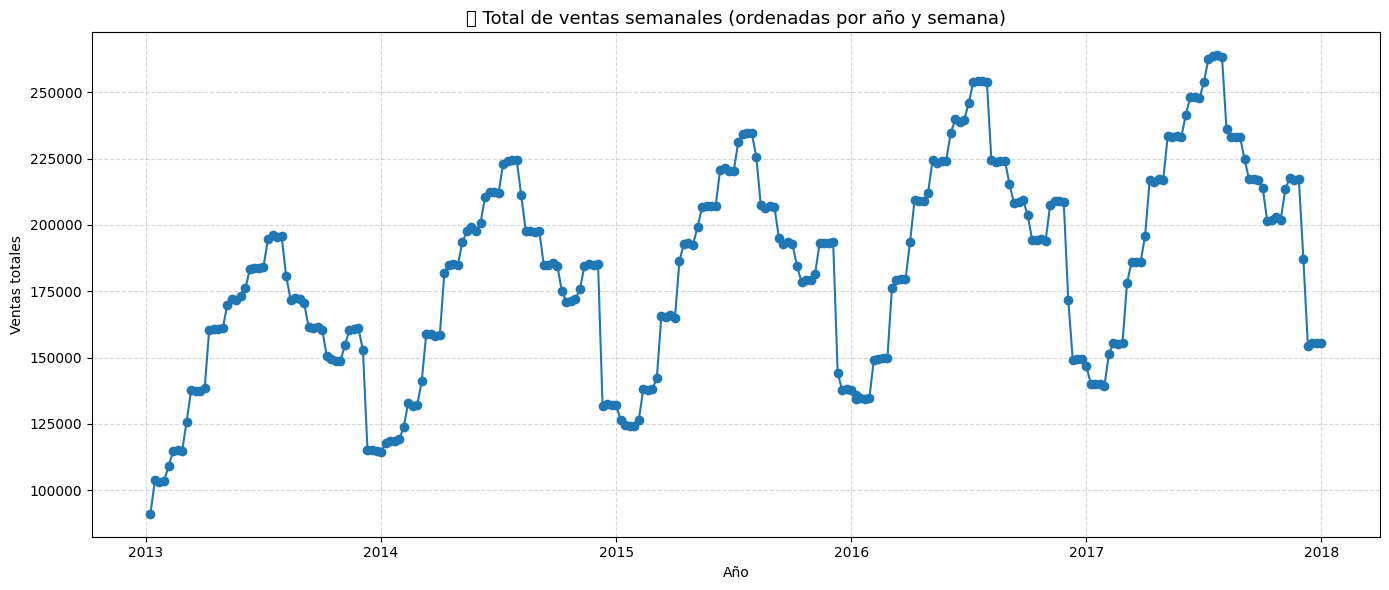

In [ ]:

# --- Agrupar las ventas semanales totales ---
ventas_semanales = (
    data_semanal
    .groupby(['year', 'week'])['sales']
    .sum()
    .reset_index()
    .sort_values(['year', 'week'])
)

# --- Crear un eje temporal continuo (año + semana/52) ---
ventas_semanales['x_axis'] = ventas_semanales['year'] + ventas_semanales['week'] / 52

# --- Graficar ---
plt.figure(figsize=(14,6))
plt.plot(
    ventas_semanales['x_axis'],
    ventas_semanales['sales'],
    marker='o',
    linestyle='-'
)
plt.title("📊 Total de ventas semanales (ordenadas por año y semana)", fontsize=13)
plt.xlabel("Año")
plt.ylabel("Ventas totales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

###  Gráfico de ventas semanales totales

Esta gráfica muestra la evolución del **total de ventas semanales** agregadas por año y semana.  
Cada punto representa la suma de las ventas de todas las tiendas y productos en una semana determinada.  
El eje X combina el año con la semana (`year + week/52`) para mostrar la serie temporal de forma continua, mientras que el eje Y indica el volumen total de ventas.  
La visualización permite identificar **patrones estacionales** y **tendencias anuales** en el comportamiento de la demanda, observando los picos y caídas cíclicas a lo largo del tiempo.


In [ ]:
# Crear las dos particiones
data_historica = data_semanal.copy()

### Análisis de la descomposición temporal de la serie de ventas

En esta celda se realiza un análisis de **series temporales** para entender los componentes que conforman la evolución de las ventas totales a lo largo del tiempo:

1. **Agrupación semanal:**  
   Se suman las ventas de todas las tiendas y productos por fecha para obtener una **serie histórica global**.

2. **Definición del índice temporal:**  
   La columna `date` se convierte en índice, lo que permite que la serie se interprete como una secuencia ordenada en el tiempo.

3. **Descomposición de la serie:**  
   Se aplica el método `seasonal_decompose` con un modelo aditivo y un periodo de 52 semanas (aproximadamente un año).  
   Esto divide la serie en tres componentes principales:
   - **Tendencia:** dirección general de crecimiento o decrecimiento.  
   - **Estacionalidad:** patrones repetitivos que se presentan en intervalos regulares (por ejemplo, ciclos anuales).  
   - **Residuo:** variaciones aleatorias no explicadas por los dos componentes anteriores.

4. **Visualización de resultados:**  
   Se grafican los tres componentes para interpretar cómo las ventas cambian con el tiempo, identificar ciclos estacionales y observar la estabilidad o volatilidad del residuo.


c:\Users\jlvar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


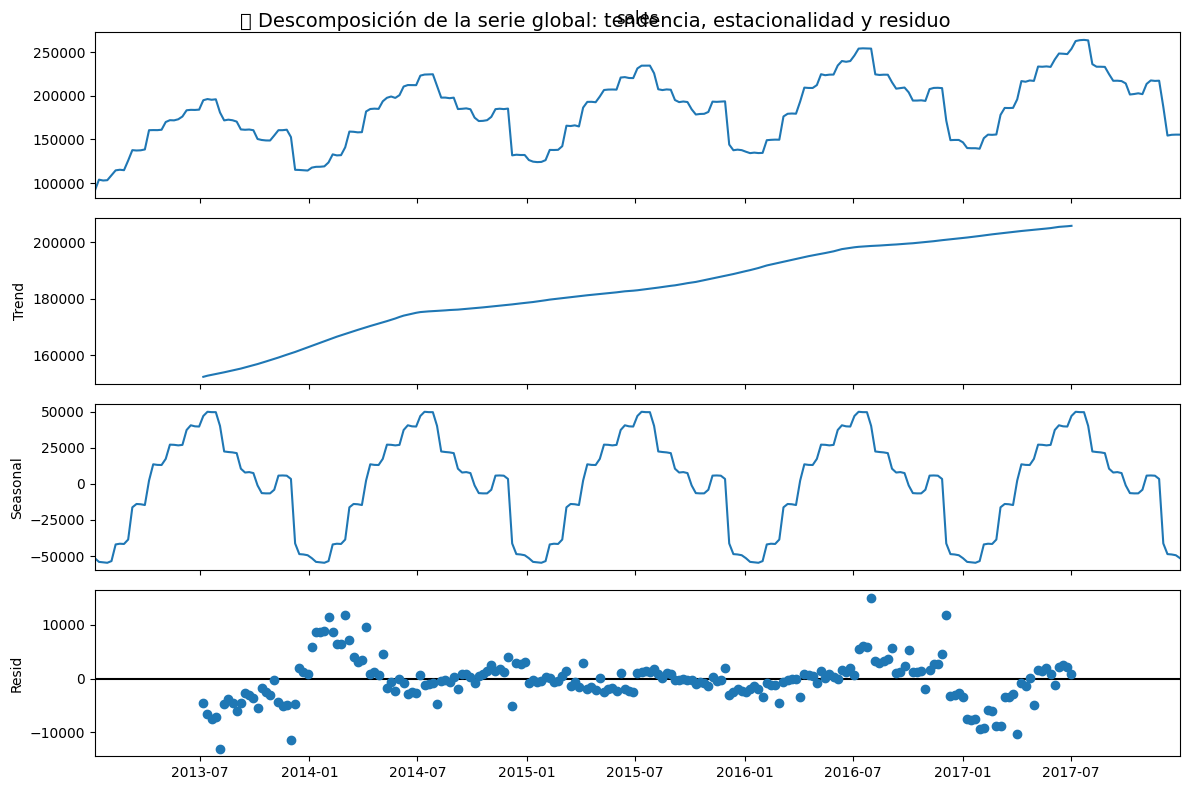

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1️ Agrupar ventas semanales totales (todas las tiendas y productos)
serie_historica = (
    data_historica
    .groupby('date')['sales']
    .sum()
    .reset_index()
    .sort_values('date')
)

# 2️ Establecer el índice temporal
serie_historica = serie_historica.set_index('date')

# 3️ Descomponer la serie (modelo aditivo con periodo de 52 semanas ≈ 1 año)
decompose_result = seasonal_decompose(serie_historica['sales'], model='additive', period=52)

# 4️ Graficar los componentes
plt.rcParams.update({'figure.figsize': (12,8)})
decompose_result.plot()
plt.suptitle('📊 Descomposición de la serie global: tendencia, estacionalidad y residuo', fontsize=14)
plt.show()


C:\Users\jlvar\AppData\Local\Temp\ipykernel_35168\3022442080.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jlvar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


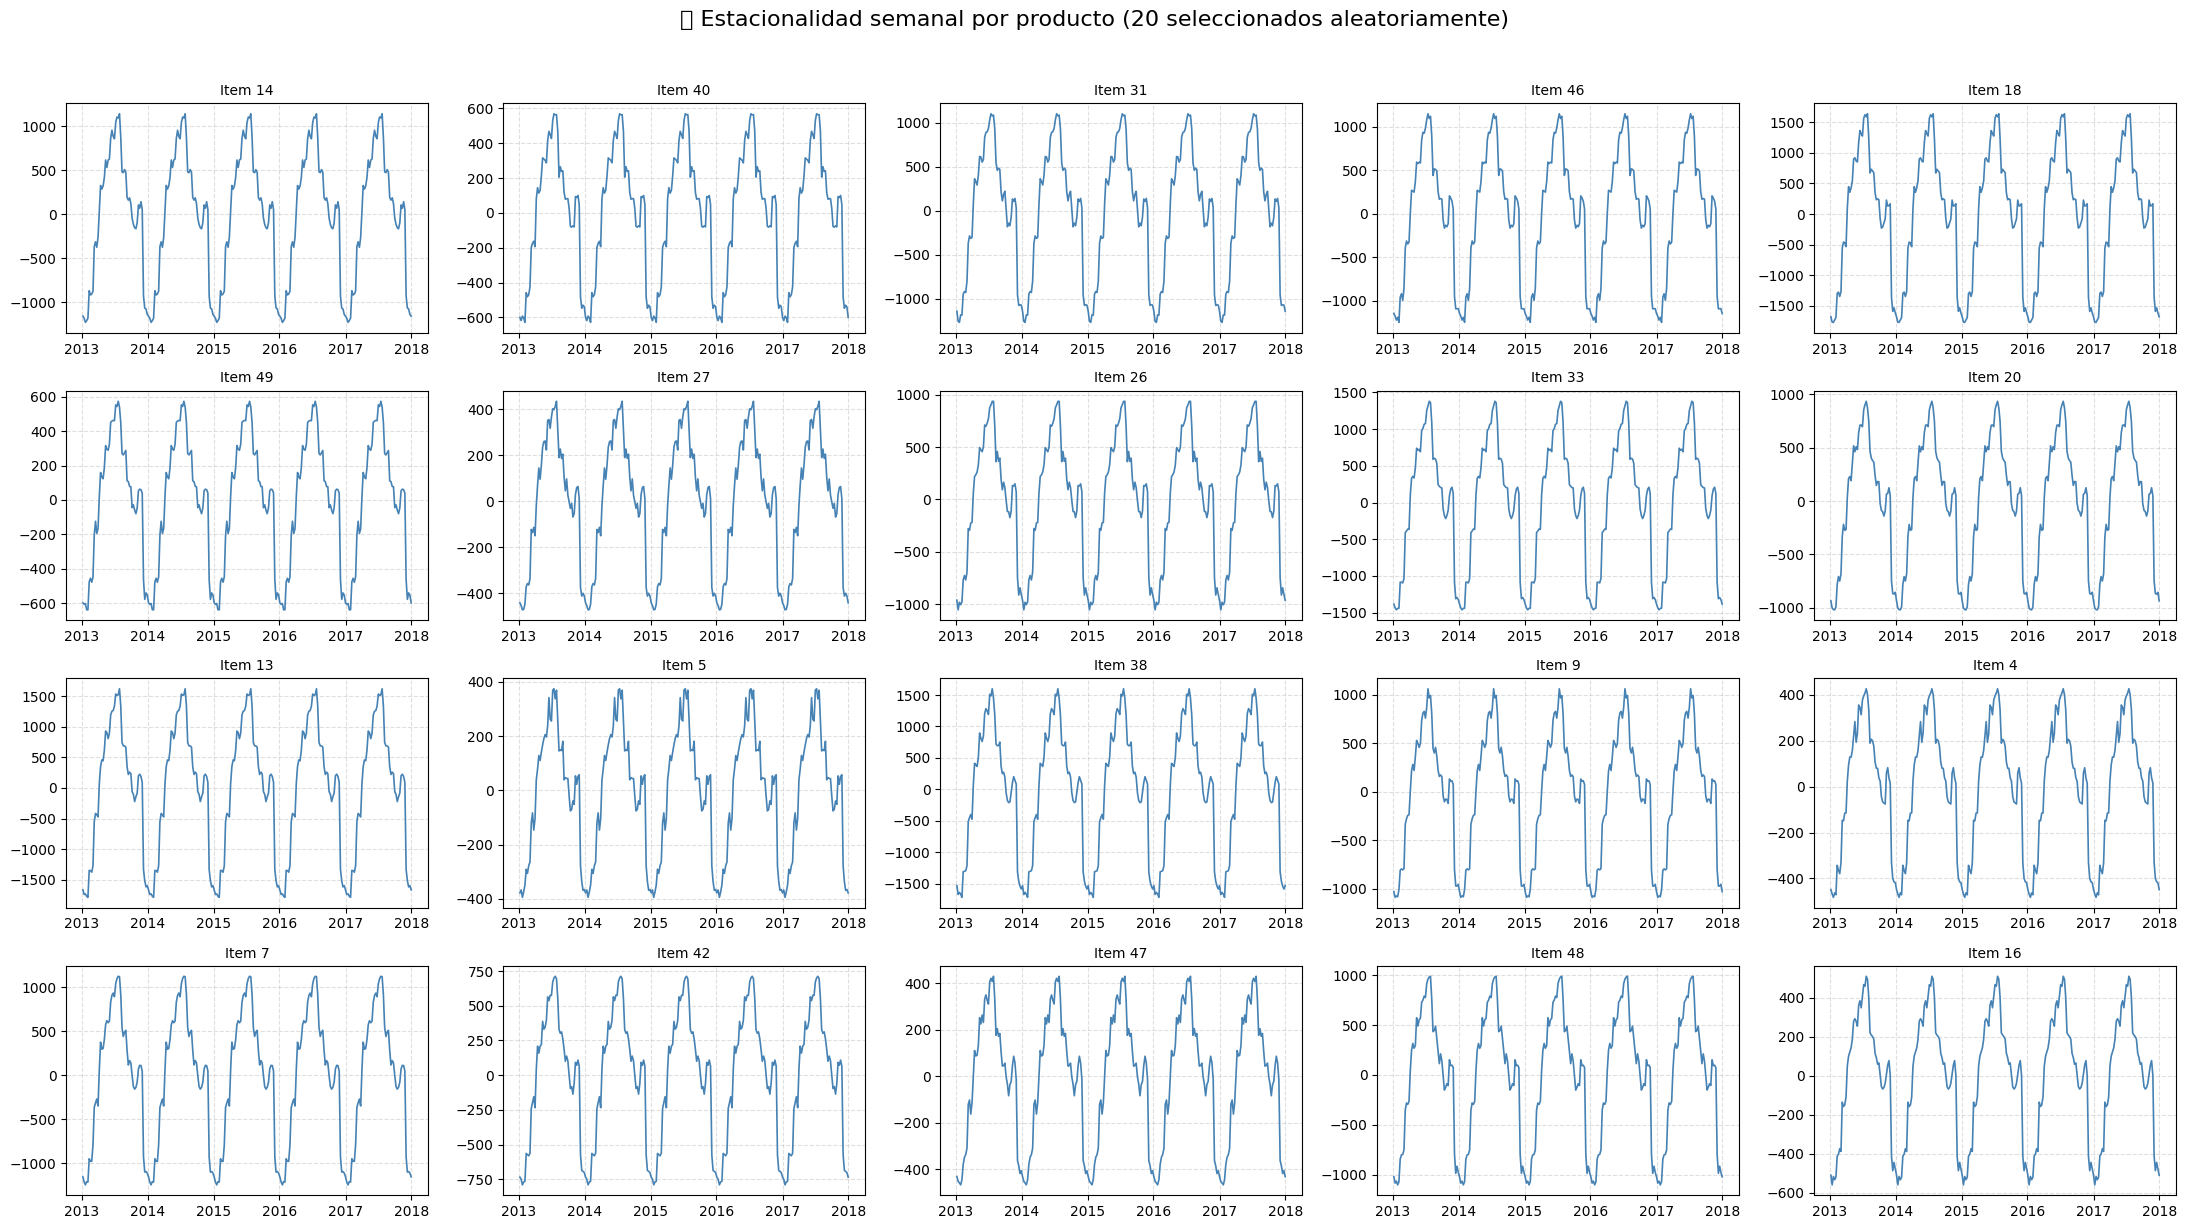

In [ ]:
# Seleccionar 20 items aleatorios
np.random.seed(42)  # para reproducibilidad
items = np.random.choice(data_historica['item'].unique(), size=20, replace=False)

# Crear figura 4x5
fig, axes = plt.subplots(4, 5, figsize=(22, 12), sharex=False, sharey=False)
axes = axes.flatten()  # Para iterar fácilmente

for idx, i in enumerate(items):
    # Filtrar ventas del producto i (suma de todas las tiendas)
    serie_item = (
        data_historica[data_historica['item'] == i]
        .groupby('date')['sales']
        .sum()
        .reset_index()
        .sort_values('date')
        .set_index('date')
    )

    # Solo descomponer si hay datos suficientes (al menos 2 años)
    if len(serie_item) >= 104:
        decompose_result = seasonal_decompose(serie_item['sales'], model='additive', period=52)
        # Graficar solo el componente estacional
        axes[idx].plot(decompose_result.seasonal, color='steelblue', linewidth=1.2)
        axes[idx].set_title(f'Item {i}', fontsize=10)
        axes[idx].grid(True, linestyle='--', alpha=0.4)
    else:
        axes[idx].text(0.5, 0.5, f'Item {i}\nSin datos suficientes', 
                       ha='center', va='center', fontsize=10, color='red')
        axes[idx].set_axis_off()

# Ocultar los ejes vacíos si hay menos de 20 items disponibles
for j in range(len(items), len(axes)):
    axes[j].set_visible(False)

# Título general
plt.suptitle('📊 Estacionalidad semanal por producto (20 seleccionados aleatoriamente)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



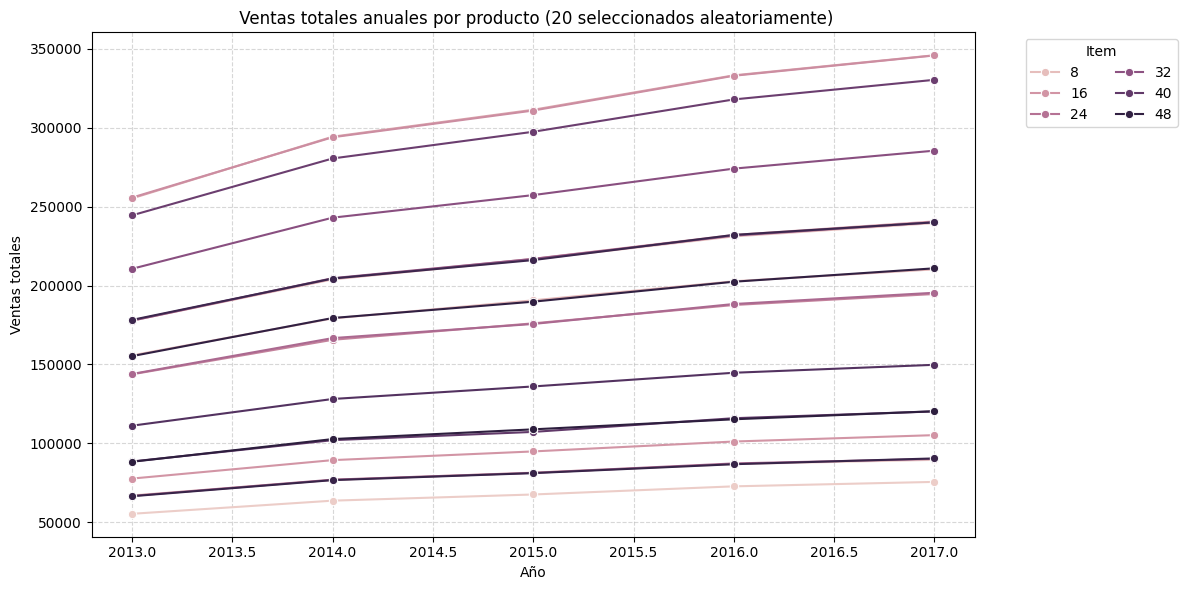

In [ ]:
# Agrupar ventas totales por año y producto
ventas_anuales_item = (
    data_historica
    .groupby(['year', 'item'])['sales']
    .sum()
    .reset_index()
)

# Seleccionar 20 productos aleatorios
np.random.seed(42)  # para reproducibilidad
items_random = np.random.choice(ventas_anuales_item['item'].unique(), size=20, replace=False)

# Filtrar el DataFrame a esos productos
ventas_anuales_random = ventas_anuales_item[ventas_anuales_item['item'].isin(items_random)]

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=ventas_anuales_random, x='year', y='sales', hue='item', marker='o')
plt.title(' Ventas totales anuales por producto (20 seleccionados aleatoriamente)')
plt.xlabel('Año')
plt.ylabel('Ventas totales')
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### 🌀 ¿Por qué usar `sen` y `cos` para la semana del año?

Las variables como **número de semana (`week`)** son **cíclicas**: después de la semana 52 vuelve la semana 1.  
Si usamos `week` como número lineal (1…52), un modelo “cree” que 52 y 1 están muy lejos, cuando en realidad son **consecutivas**.  
Para que el modelo entienda esa circularidad, mapeamos la semana a un **círculo unitario**:

\[
\text{sin\_week}=\sin\left(2\pi\cdot \frac{\text{week}}{52}\right),\quad
\text{cos\_week}=\cos\left(2\pi\cdot \frac{\text{week}}{52}\right)
\]

**Qué logramos:**
- Representar la **posición dentro del ciclo anual** (como un ángulo).
- Hacer que **semana 52 y 1 queden cercanas** en el espacio (sen–cos).
- Evitar saltos artificiales que dificultan aprender la **estacionalidad**.

**¿Por qué dos columnas?**  
Con solo `sin` o solo `cos` habría ambigüedad (distintos ángulos pueden dar el mismo valor).  
Con **ambas** coordenadas el punto queda bien definido sobre el círculo.

**Notas prácticas:**
- Si algún año trae **semana 53**, puedes usar divisor 52.18≈(52+53)/2 o normalizar por el número real de semanas de ese año; lo importante es mantener la **circularidad**.
- Estas features funcionan muy bien con modelos tabulares (GBM, RF, XGBoost, etc.) y redes neuronales.

En el código, copiamos el histórico, aseguramos que `week` sea entero y creamos `sin_week` y `cos_week`.  
El `head()` te deja verificar que las nuevas columnas estén calculadas correctamente.


In [ ]:
# Copiar el dataset base
data_modelo = data_historica.copy()

# Asegurar que la columna 'week' esté en formato numérico
data_modelo['week'] = data_modelo['week'].astype(int)

# Crear las variables cíclicas (semanales)
data_modelo['sin_week'] = np.sin(2 * np.pi * data_modelo['week'] / 52)
data_modelo['cos_week'] = np.cos(2 * np.pi * data_modelo['week'] / 52)

# Verificar resultado
data_modelo.head(10)


,store,item,date,sales,year,week,sin_week,cos_week
0,1,1,2013-01-06,73,2013,1,0.120537,0.992709
1,1,1,2013-01-13,66,2013,2,0.239316,0.970942
2,1,1,2013-01-20,80,2013,3,0.354605,0.935016
3,1,1,2013-01-27,70,2013,4,0.464723,0.885456
4,1,1,2013-02-03,86,2013,5,0.568065,0.822984
5,1,1,2013-02-10,82,2013,6,0.663123,0.748511
6,1,1,2013-02-17,80,2013,7,0.748511,0.663123
7,1,1,2013-02-24,78,2013,8,0.822984,0.568065
8,1,1,2013-03-03,83,2013,9,0.885456,0.464723
9,1,1,2013-03-10,97,2013,10,0.935016,0.354605


###  Creación de variables de rezago y ventanas móviles

En esta celda se generan las **características temporales** que permiten a los modelos de Machine Learning capturar la **dependencia temporal** y la **tendencia de las ventas** en el tiempo:

1. **Orden temporal:**  
   Se ordenan los datos por `store`, `item` y `date` para garantizar la secuencia cronológica correcta dentro de cada serie individual (tienda–producto).

2. **Variables de rezago (`lag`):**  
   Con `shift(lag)` se crean columnas que contienen las ventas de semanas anteriores (1, 2, 4, 8 y 12).  
   Estas variables permiten al modelo aprender patrones de **autocorrelación**, es decir, cómo las ventas pasadas influyen en las futuras.

3. **Ventanas móviles (`rolling`):**  
   Se calculan el **promedio** y la **desviación estándar** de las ventas en las últimas 4 y 8 semanas usando `rolling(window)`.  
   Esto ayuda a representar **tendencias recientes** y **variabilidad** del comportamiento del producto.

4. **Prevención de fuga de información:**  
   Se aplica `shift(1)` antes del cálculo de las ventanas para asegurarse de que solo se utilicen datos **anteriores** a la semana actual (nunca del futuro).

5. **Limpieza final:**  
   Se eliminan las filas con `NaN`, generadas en las primeras semanas donde no existen suficientes observaciones previas para calcular los rezagos o promedios.

En conjunto, estas transformaciones enriquecen la serie temporal con información contextual, haciendo posible que el modelo capture **tendencias, estacionalidad y persistencia temporal** en las ventas.


In [ ]:
# --- Crear variables de rezago y ventanas móviles ---

# Ordenar correctamente
data_modelo = data_modelo.sort_values(['store', 'item', 'date'])

#  Lags de 1, 2, 4, 8 y 12 semanas
for lag in [1, 2, 4, 8, 12]:
    data_modelo[f'sales_lag_{lag}'] = (
        data_modelo.groupby(['store', 'item'])['sales']
        .shift(lag)
    )

#  Ventanas móviles de 4 y 8 semanas (usando transform en lugar de reset_index)
for window in [4, 8]:
    data_modelo[f'rolling_mean_{window}'] = (
        data_modelo.groupby(['store', 'item'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window).mean())
    )
    
    data_modelo[f'rolling_std_{window}'] = (
        data_modelo.groupby(['store', 'item'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window).std())
    )

#  Eliminar filas con NaN generadas por los rezagos iniciales
data_modelo = data_modelo.dropna().reset_index(drop=True)

#  Revisar estructura final
print(data_modelo.shape)
data_modelo.head()



(124500, 17)


,store,item,date,sales,year,week,sin_week,cos_week,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8,sales_lag_12,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8
0,1,1,2013-03-31,109,2013,13,1.000000,-1.608123e-16,122.0,101.0,83.0,86.0,73.0,100.75,16.132266,91.125,14.913441
1,1,1,2013-04-07,131,2013,14,0.992709,-1.205367e-01,109.0,122.0,97.0,82.0,66.0,107.25,11.026483,94.000,15.964246
2,1,1,2013-04-14,128,2013,15,0.970942,-2.393157e-01,131.0,109.0,101.0,80.0,80.0,115.75,13.351030,100.125,19.671862
3,1,1,2013-04-21,125,2013,16,0.935016,-3.546049e-01,128.0,131.0,122.0,78.0,70.0,122.50,9.746794,106.125,19.974537
4,1,1,2013-04-28,112,2013,17,0.885456,-4.647232e-01,125.0,128.0,109.0,83.0,86.0,123.25,9.810708,112.000,17.246118


In [63]:
data_modelo = data_modelo.drop(columns=["date"])

In [64]:
data_modelo.head()

,store,item,sales,year,week,sin_week,cos_week,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8,sales_lag_12,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8
0,1,1,109,2013,13,1.000000,-1.608123e-16,122.0,101.0,83.0,86.0,73.0,100.75,16.132266,91.125,14.913441
1,1,1,131,2013,14,0.992709,-1.205367e-01,109.0,122.0,97.0,82.0,66.0,107.25,11.026483,94.000,15.964246
2,1,1,128,2013,15,0.970942,-2.393157e-01,131.0,109.0,101.0,80.0,80.0,115.75,13.351030,100.125,19.671862
3,1,1,125,2013,16,0.935016,-3.546049e-01,128.0,131.0,122.0,78.0,70.0,122.50,9.746794,106.125,19.974537
4,1,1,112,2013,17,0.885456,-4.647232e-01,125.0,128.0,109.0,83.0,86.0,123.25,9.810708,112.000,17.246118


### ⏳ Por qué dividir los datos por año y no con `train_test_split`

En problemas de **series temporales**, como el pronóstico de demanda, el tiempo tiene una **dirección natural**: el modelo aprende del pasado para predecir el futuro.  
Por eso, no podemos dividir los datos de forma aleatoria (como hace `train_test_split` de scikit-learn), ya que eso mezclaría semanas pasadas y futuras en los conjuntos de entrenamiento y prueba.

En lugar de eso, la división se hace **respetando la secuencia temporal**:
- `train`: incluye todas las observaciones **anteriores a 2017**, que representan el historial de ventas.  
- `test`: contiene los datos de **2017**, que simulan el "futuro" que el modelo debe predecir.

Este enfoque:
- Evita **fugas de información**, ya que el modelo nunca ve datos de fechas posteriores durante el entrenamiento.  
- Permite evaluar el rendimiento en un escenario **realista de forecasting**, donde solo disponemos del pasado.  
- Garantiza que los patrones aprendidos reflejen **causalidad temporal** (lo que pasa antes influye en lo que viene después).


In [ ]:
# ===============================================
#  División temporal y definición de variables
# ===============================================

# Separar los datos por año:
# Entrenamiento: todo antes de 2017
# Prueba: solo el año 2017 (último año histórico)
train = data_modelo[data_modelo['year'] < 2017].copy()
test = data_modelo[data_modelo['year'] == 2017].copy()

# Definir las variables predictoras (features)
# Incluyen información temporal, rezagos y estadísticas móviles
features = [
    'store', 'item', 'year', 'week', 
    'sin_week', 'cos_week',                # variables cíclicas (estacionalidad)
    'sales_lag_1', 'sales_lag_2', 'sales_lag_4',   # rezagos (memoria temporal)
    'sales_lag_8', 'sales_lag_12',
    'rolling_mean_4', 'rolling_std_4',     # medias y desviaciones móviles
    'rolling_mean_8', 'rolling_std_8'
]

# Variable objetivo: la demanda semanal (ventas)
target = 'sales'

# Dividir en conjuntos de entrenamiento y prueba
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Mostrar dimensiones de los datasets generados
print("===== 🧾 Dimensiones de los datasets =====")
print(f"data_modelo: {data_modelo.shape}")  # dataset completo
print(f"train:       {train.shape}")        # conjunto de entrenamiento
print(f"test:        {test.shape}")         # conjunto de prueba
print(f"X_train:     {X_train.shape}")      # variables predictoras (train)
print(f"y_train:     {y_train.shape}")      # variable objetivo (train)
print(f"X_test:      {X_test.shape}")       # variables predictoras (test)
print(f"y_test:      {y_test.shape}")       # variable objetivo (test)


===== 🧾 Dimensiones de los datasets =====
data_modelo: (124500, 16)
train:       (98500, 16)
test:        (26000, 16)
X_train:     (98500, 15)
y_train:     (98500,)
X_test:      (26000, 15)
y_test:      (26000,)


###  Comparación de modelos de regresión

En esta celda se comparan diferentes algoritmos de regresión para determinar cuál predice mejor la demanda.  
El objetivo es evaluar el rendimiento de modelos con distintos enfoques (lineal, basado en árboles y ensambles) sobre el mismo conjunto de datos.

**1️ Modelos evaluados:**
- **Linear Regression:** modelo base que asume relaciones lineales entre las variables.  
- **Random Forest:** conjunto de árboles independientes que mejora la precisión al reducir el sobreajuste.  
- **Gradient Boosting:** modelo secuencial donde cada árbol corrige los errores del anterior.  
- **XGBoost:** versión optimizada del boosting, eficiente y con excelente rendimiento en datos tabulares.

**2️ Métricas utilizadas:**
- **RMSE (Root Mean Squared Error):** mide el error promedio en las predicciones; valores menores indican mayor precisión.  
- **R² (Coeficiente de determinación):** mide qué proporción de la variabilidad de las ventas es explicada por el modelo.

**3️ Flujo del proceso:**
- Se entrena cada modelo con los mismos datos (`X_train`, `y_train`).  
- Se evalúa su desempeño sobre el conjunto de prueba (`X_test`, `y_test`).  
- Los resultados se organizan en un DataFrame y se visualizan con un gráfico de barras, donde un **RMSE menor** representa mejor desempeño.


⚙️ Entrenando Linear Regression...
⚙️ Entrenando Random Forest...


c:\Users\jlvar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jlvar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


⚙️ Entrenando Gradient Boosting...


c:\Users\jlvar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


⚙️ Entrenando XGBoost...


c:\Users\jlvar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jlvar\AppData\Local\Temp\ipykernel_35168\2565759866.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x="RMSE", y="Modelo", palette="viridis")



📊 Resultados comparativos:

              Modelo       RMSE        R²
2  Gradient Boosting  23.054366  0.987613
3            XGBoost  23.186263  0.987471
1      Random Forest  25.318052  0.985061
0  Linear Regression  32.919898  0.974744


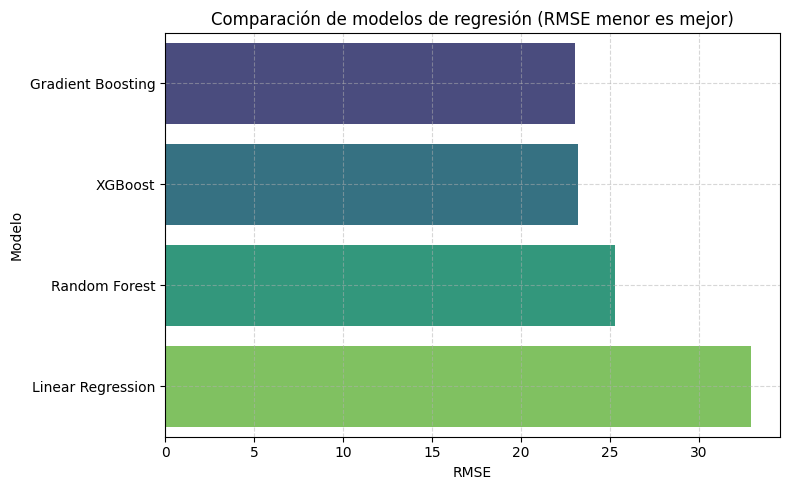

In [ ]:
# =====================================
# 🚀 Comparación de modelos de regresión
# =====================================

# --- 3️⃣ Definir modelos a comparar ---
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method='hist'),
}

# --- 4️⃣ Entrenar y evaluar ---
resultados = []

for nombre, modelo in modelos.items():
    print(f"⚙️ Entrenando {nombre}...")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({"Modelo": nombre, "RMSE": rmse, "R²": r2})

# --- 5️⃣ Mostrar resultados ---
df_resultados = pd.DataFrame(resultados).sort_values("RMSE")
print("\n📊 Resultados comparativos:\n")
print(df_resultados)

# --- 6️⃣ Visualizar comparativa ---
plt.figure(figsize=(8,5))
sns.barplot(data=df_resultados, x="RMSE", y="Modelo", palette="viridis")
plt.title("Comparación de modelos de regresión (RMSE menor es mejor)")
plt.xlabel("RMSE")
plt.ylabel("Modelo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



###  Creación del conjunto base para el pronóstico 2018

En esta celda se construye la estructura que servirá como **base temporal** para realizar las predicciones del año 2018.  
El objetivo es generar todas las combinaciones posibles de **tienda (`store`)**, **producto (`item`)** y **semana del año (`week`)**, asegurando que cada par tienda–producto tenga una fila para cada semana del año.

1. **Listas únicas de tiendas y productos:**  
   Se extraen los valores únicos del histórico (`data_modelo`) para conocer todas las tiendas y productos disponibles.

2. **Combinaciones tienda–producto:**  
   Con `pd.MultiIndex.from_product()` se genera la tabla con todas las combinaciones posibles entre tiendas y productos, asegurando que ninguna quede por fuera.

3. **Semanas del año 2018:**  
   Se crea un DataFrame con las semanas del 1 al 52 y el año correspondiente.

4. **Cruce cartesiano:**  
   Se combinan las dos tablas (tienda–producto y semanas) mediante una clave auxiliar (`key=1`), generando así **una fila por cada semana del 2018 para cada tienda y producto**.

5. **Orden y limpieza:**  
   Se organizan las columnas y se reinicia el índice para dejar el dataset limpio y ordenado.

El resultado es un DataFrame con la **estructura temporal completa de 2018**, lista para añadir variables adicionales (como `sin_week`, `cos_week` y predicciones de ventas).


In [68]:


# 1️ Obtener listas únicas de tiendas y productos del histórico
stores = data_modelo['store'].unique()
items = data_modelo['item'].unique()

# 2️ Crear todas las combinaciones tienda-producto
base = pd.MultiIndex.from_product([stores, items], names=['store', 'item']).to_frame(index=False)

# 3️ Crear las 52 semanas del año 2018
weeks_2018 = pd.DataFrame({'week': np.arange(1, 53), 'year': 2018})

# 4️ Combinar para obtener todas las combinaciones posibles
data_2018 = base.assign(key=1).merge(weeks_2018.assign(key=1), on='key').drop(columns='key')

# 5️ Ordenar columnas y revisar
data_2018 = data_2018[['store', 'item', 'year', 'week']].sort_values(['store', 'item', 'week']).reset_index(drop=True)

# ✅ Resultado
print(f"🔢 Filas totales: {data_2018.shape[0]}")
data_2018.head(10)


🔢 Filas totales: 26000


,store,item,year,week
0,1,1,2018,1
1,1,1,2018,2
2,1,1,2018,3
3,1,1,2018,4
4,1,1,2018,5
5,1,1,2018,6
6,1,1,2018,7
7,1,1,2018,8
8,1,1,2018,9
9,1,1,2018,10


In [69]:
import numpy as np

# Añadir variables cíclicas de la semana
data_2018['sin_week'] = np.sin(2 * np.pi * data_2018['week'] / 52)
data_2018['cos_week'] = np.cos(2 * np.pi * data_2018['week'] / 52)

# Ver resultado
data_2018.head(10)


,store,item,year,week,sin_week,cos_week
0,1,1,2018,1,0.120537,0.992709
1,1,1,2018,2,0.239316,0.970942
2,1,1,2018,3,0.354605,0.935016
3,1,1,2018,4,0.464723,0.885456
4,1,1,2018,5,0.568065,0.822984
5,1,1,2018,6,0.663123,0.748511
6,1,1,2018,7,0.748511,0.663123
7,1,1,2018,8,0.822984,0.568065
8,1,1,2018,9,0.885456,0.464723
9,1,1,2018,10,0.935016,0.354605


###  Integración del histórico con el calendario de predicción

En esta celda se combina el **histórico de ventas** (`data_modelo`) con el **conjunto base de 2018** (`data_2018`) para crear un único DataFrame continuo llamado `data_full`.

1. **Copia del histórico:**  
   Se realiza una copia del dataset original para evitar modificar los datos base.

2. **Preparación del dataset futuro:**  
   En `data_2018` se añade la columna `sales` con valores `NaN`, ya que las ventas de 2018 aún no son conocidas y serán las que el modelo deberá predecir.

3. **Unión de histórico y futuro:**  
   Se usa `pd.concat()` para unir ambos conjuntos, manteniendo todas las filas y columnas.  
   Esto permite que las semanas de 2018 queden alineadas cronológicamente después del histórico (hasta 2017).

4. **Ordenamiento temporal:**  
   Se ordenan los registros por `store`, `item`, `year` y `week`, garantizando que las observaciones sigan el orden correcto dentro de cada serie temporal.

El resultado, `data_full`, contiene tanto los datos reales del pasado como las semanas futuras a predecir, formando la base para el **proceso de forecasting recursivo**.


In [70]:
# Copiar el histórico
data_full = data_modelo.copy()

# Agregar el dataset de 2018 (sin ventas todavía)
data_2018['sales'] = np.nan  # placeholder
data_full = pd.concat([data_full, data_2018], ignore_index=True)
data_full = data_full.sort_values(['store', 'item', 'year', 'week']).reset_index(drop=True)

print(f"📊 Total filas combinadas: {data_full.shape[0]}")
data_full.tail(10)


📊 Total filas combinadas: 150500


,store,item,sales,year,week,sin_week,cos_week,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8,sales_lag_12,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8
150490,10,50,NaN,2018,43,-8.854560e-01,0.464723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150491,10,50,NaN,2018,44,-8.229839e-01,0.568065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150492,10,50,NaN,2018,45,-7.485107e-01,0.663123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150493,10,50,NaN,2018,46,-6.631227e-01,0.748511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150494,10,50,NaN,2018,47,-5.680647e-01,0.822984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150495,10,50,NaN,2018,48,-4.647232e-01,0.885456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150496,10,50,NaN,2018,49,-3.546049e-01,0.935016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150497,10,50,NaN,2018,50,-2.393157e-01,0.970942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150498,10,50,NaN,2018,51,-1.205367e-01,0.992709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150499,10,50,NaN,2018,52,6.432491e-16,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Función `actualizar_lags_y_rollings()`

Esta función permite **recalcular dinámicamente** las variables de **rezago (lag)** y **ventanas móviles (rolling)** dentro de cada grupo de tienda y producto (`store`, `item`).  
Es fundamental para el proceso de **predicción recursiva**, donde las nuevas ventas pronosticadas se incorporan semana a semana y los lags deben actualizarse tras cada predicción.

**Explicación paso a paso:**

1. **Ordenamiento temporal:**  
   Se ordenan los registros por `store`, `item`, `year` y `week` para asegurar que las operaciones se realicen en el orden cronológico correcto dentro de cada serie.

2. **Cálculo de rezagos (`lag`):**  
   Con `shift(lag)` se generan columnas que contienen las ventas de semanas anteriores (1, 2, 4, 8 y 12).  
   Esto permite al modelo conocer el comportamiento pasado más reciente de cada tienda y producto.

3. **Cálculo de ventanas móviles (`rolling`):**  
   Para cada grupo, se calcula la **media** y la **desviación estándar** de las ventas en las últimas 4 y 8 semanas, usando `transform()` para mantener la estructura del DataFrame.  
   El `shift(1)` evita usar información de la semana actual (previene fuga de información).

4. **Retorno actualizado:**  
   Devuelve el DataFrame con todas las variables de rezago y tendencia actualizadas, listo para usar en la siguiente iteración de predicción.

Esta función mantiene la coherencia temporal del dataset durante el forecasting, asegurando que las nuevas predicciones alimenten correctamente los indicadores históricos.


In [71]:
def actualizar_lags_y_rollings(df):
    """
    Recalcula las variables de rezago y ventanas móviles
    dentro de cada grupo (store, item).
    """
    df = df.sort_values(['store', 'item', 'year', 'week'])
    for lag in [1, 2, 4, 8, 12]:
        df[f'sales_lag_{lag}'] = (
            df.groupby(['store', 'item'])['sales'].shift(lag)
        )
    for window in [4, 8]:
        df[f'rolling_mean_{window}'] = (
            df.groupby(['store', 'item'])['sales']
            .transform(lambda x: x.shift(1).rolling(window).mean())
        )
        df[f'rolling_std_{window}'] = (
            df.groupby(['store', 'item'])['sales']
            .transform(lambda x: x.shift(1).rolling(window).std())
        )
    return df


In [ ]:
data_full = actualizar_lags_y_rollings(data_full)
# Confirmar que los primeros lags de 2018 (semana 1) están poblados
data_full[(data_full['year'] == 2018) & (data_full['week'] == 1)].head()

,store,item,sales,year,week,sin_week,cos_week,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8,sales_lag_12,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8
249,1,1,NaN,2018,1,0.120537,0.992709,127.0,97.0,126.0,145.0,147.0,116.75,13.913423,136.125,26.172164
550,1,2,NaN,2018,1,0.120537,0.992709,358.0,292.0,319.0,460.0,382.0,324.00,27.166155,386.250,69.151490
851,1,3,NaN,2018,1,0.120537,0.992709,185.0,177.0,209.0,263.0,245.0,194.50,15.947832,225.375,37.140419
1152,1,4,NaN,2018,1,0.120537,0.992709,121.0,110.0,108.0,177.0,171.0,110.75,7.274384,136.875,31.579548
1453,1,5,NaN,2018,1,0.120537,0.992709,99.0,84.0,92.0,131.0,117.0,96.50,11.445523,114.750,23.057382


In [ ]:
# =====================================
#  Entrenar Gradient Boosting Regressor
# =====================================

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- 1️ Definir las columnas de entrada ---
features = [
    'store', 'item', 'year', 'week',
    'sin_week', 'cos_week',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_4',
    'sales_lag_8', 'sales_lag_12',
    'rolling_mean_4', 'rolling_std_4',
    'rolling_mean_8', 'rolling_std_8'
]
target = 'sales'

# --- 2️ Usar solo datos con ventas reales (hasta 2017) ---
train = data_full[data_full['year'] <= 2017].dropna(subset=['sales'])
train = train.fillna(0).reset_index(drop=True)
X_train, y_train = train[features], train[target]

# --- 3️ Inicializar y entrenar el modelo ---
gb_model = GradientBoostingRegressor(
    n_estimators=500,       # número de árboles
    learning_rate=0.05,     # paso de aprendizaje
    max_depth=6,            # profundidad máxima de cada árbol
    subsample=0.8,          # fracción de datos usada en cada iteración
    random_state=42
)

print("===== 🧾 Dimensiones del conjunto de entrenamiento =====")
print(f"X_train shape: {X_train.shape}")  # filas y columnas de features
print(f"y_train shape: {y_train.shape}")  # solo filas (target)

print("\n===== 🔍 Verificación rápida =====")
print(f"Número de observaciones: {len(X_train)}")
print(f"Número de variables (features): {X_train.shape[1]}")



===== 🧾 Dimensiones del conjunto de entrenamiento =====
X_train shape: (124500, 15)
y_train shape: (124500,)

===== 🔍 Verificación rápida =====
Número de observaciones: 124500
Número de variables (features): 15


In [88]:
print("⚙️ Entrenando modelo Gradient Boosting...")
gb_model.fit(X_train, y_train)
print("✅ Entrenamiento completado.")

# --- 4️⃣ Evaluar rendimiento sobre el histórico ---
y_pred_train = gb_model.predict(X_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
r2 = r2_score(y_train, y_pred_train)

print(f"\n📊 Rendimiento en entrenamiento:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


⚙️ Entrenando modelo Gradient Boosting...
✅ Entrenamiento completado.

📊 Rendimiento en entrenamiento:
RMSE: 20.22
R²: 0.989


c:\Users\jlvar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import joblib
joblib.dump(gb_model, "gradient_boosting_model.pkl")
gb_model = joblib.load("gradient_boosting_model.pkl")

###  Predicción recursiva semana a semana (forecast 2018)

En esta celda se realiza la **predicción automática de las ventas para el año 2018**, avanzando semana a semana y actualizando los valores calculados en cada paso.  
Este enfoque se conoce como **forecasting recursivo**, y permite extender las predicciones hacia el futuro sin disponer de datos reales de ventas.

**1️ Definición de las variables de entrada:**  
Se asegura que las columnas (`features`) usadas en la predicción sean exactamente las mismas que se utilizaron durante el entrenamiento del modelo (`gb_model`).

**2️ Actualización inicial de rezagos:**  
Antes de empezar el pronóstico, se llama a la función `actualizar_lags_y_rollings()` para calcular los rezagos y promedios móviles con los datos históricos más recientes (hasta 2017).

**3️ Predicción recursiva:**  
El bucle `for week in tqdm(range(1, 53))` recorre las 52 semanas del año 2018:
- Se filtran las filas de la semana actual sin valor de ventas (`sales` = NaN).  
- Se genera la predicción (`y_pred`) usando el modelo entrenado.  
- Los valores pronosticados se insertan en `data_full`.  
- Finalmente, se **recalcula** la información de `lag` y `rolling` para que las predicciones recién generadas se utilicen en la siguiente semana.



Este bloque simula el comportamiento real de un sistema de pronóstico operativo:  
cada semana se predice la demanda, se actualizan las variables con esa información y el modelo continúa aprendiendo del “pasado” más reciente.


In [ ]:
# ===============================================
#  Predicción recursiva de la demanda para 2018
# ===============================================

# tqdm permite mostrar una barra de progreso visual durante el bucle
from tqdm import tqdm

# --- 1️ Definir las variables predictoras ---
# Estas deben ser exactamente las mismas usadas en el entrenamiento del modelo
features = [
    'store', 'item', 'year', 'week', 
    'sin_week', 'cos_week',                   # variables cíclicas (representan el patrón semanal)
    'sales_lag_1', 'sales_lag_2', 'sales_lag_4',  # rezagos (memoria del pasado)
    'sales_lag_8', 'sales_lag_12',
    'rolling_mean_4', 'rolling_std_4',        # medias y desviaciones móviles (tendencias locales)
    'rolling_mean_8', 'rolling_std_8'
]

# --- 2️ Recalcular los lags antes de iniciar ---
# Se asegura que las variables de rezago y rolling estén actualizadas
# con la última información del histórico antes de iniciar la predicción
data_full = actualizar_lags_y_rollings(data_full)

# --- 3️ Proceso de predicción recursiva ---
# Se realiza la predicción semana a semana (1 a 52) para todo el año 2018
for week in tqdm(range(1, 53)):  # tqdm agrega una barra de progreso visual
    
    # Filtro: filas correspondientes a la semana actual de 2018 que aún no tienen predicción
    mask = (
        (data_full['year'] == 2018) &
        (data_full['week'] == week) &
        (data_full['sales'].isna())
    )
    
    # Extraer las características para esa semana
    X_pred = data_full.loc[mask, features]
    
    # Si existen filas para predecir (evita errores con semanas vacías)
    if not X_pred.empty:
        # 🔹 Generar predicciones con el modelo entrenado (Gradient Boosting)
        y_pred = gb_model.predict(X_pred)
        
        # 🔹 Asignar las predicciones al dataset principal
        data_full.loc[mask, 'sales'] = y_pred

        # 🔹 Recalcular los rezagos y promedios móviles
        # Esto permite que las nuevas predicciones alimenten las variables de las semanas siguientes
        data_full = actualizar_lags_y_rollings(data_full)

#  Al finalizar, 'data_full' contendrá las predicciones para las 52 semanas del año 2018



100%|██████████| 52/52 [00:32<00:00,  1.58it/s]


C:\Users\jlvar\AppData\Local\Temp\ipykernel_35168\2861791789.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jlvar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


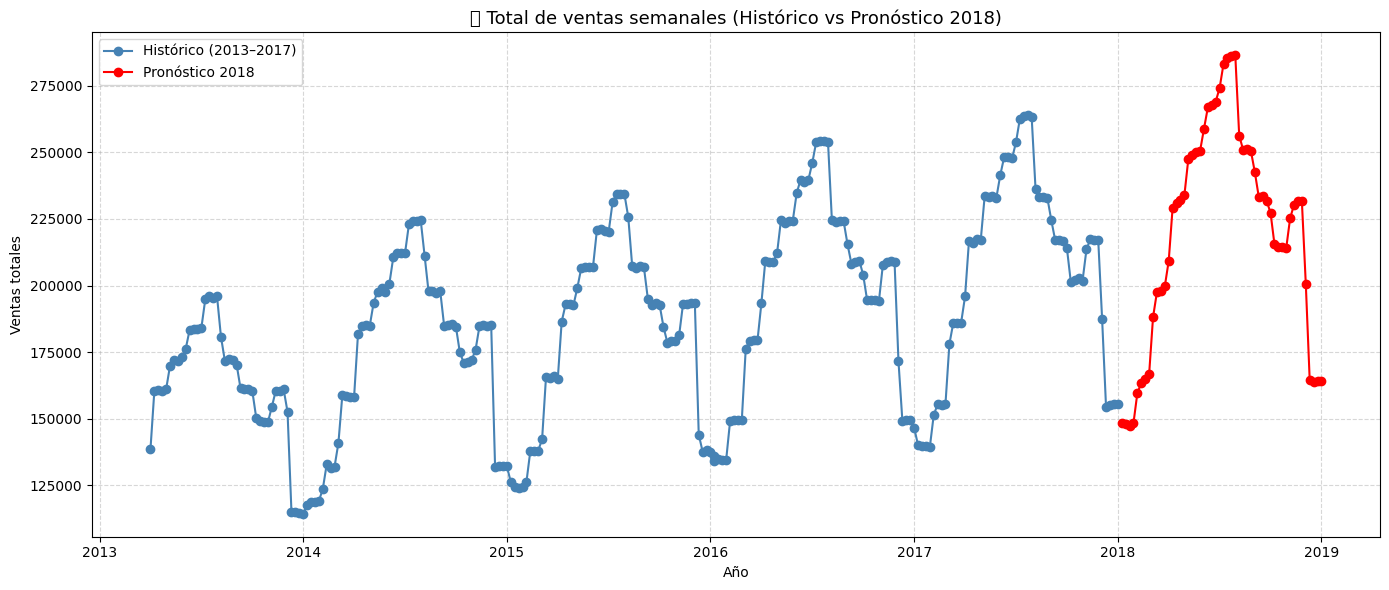

In [ ]:
# --- 1️⃣ Agrupar las ventas semanales totales ---
ventas_semanales = (
    data_full
    .groupby(['year', 'week'])['sales']
    .sum()
    .reset_index()
    .sort_values(['year', 'week'])
)

# --- 2️⃣ Separar histórico (<=2017) y pronóstico (2018) ---
historico = ventas_semanales[ventas_semanales['year'] <= 2017]
forecast  = ventas_semanales[ventas_semanales['year'] == 2018]

# --- 3️⃣ Graficar ---
plt.figure(figsize=(14,6))

# Histórico en azul
plt.plot(historico['year'] + historico['week']/52,
         historico['sales'],
         color='steelblue', marker='o', label='Histórico (2013–2017)')

# Pronóstico en rojo
plt.plot(forecast['year'] + forecast['week']/52,
         forecast['sales'],
         color='red', marker='o', label='Pronóstico 2018')

# --- 4️⃣ Estética del gráfico ---
plt.title("📊 Total de ventas semanales (Histórico vs Pronóstico 2018)", fontsize=13)
plt.xlabel("Año")
plt.ylabel("Ventas totales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, Dropdown

# --- Preparar el DataFrame base ---
# Agrupar por semana, tienda e item
ventas_interact = (
    data_full
    .groupby(['store', 'item', 'year', 'week'])['sales']
    .sum()
    .reset_index()
    .sort_values(['store', 'item', 'year', 'week'])
)

# --- Obtener valores únicos ---
stores = sorted(ventas_interact['store'].unique())
items = sorted(ventas_interact['item'].unique())

# --- Función para actualizar el gráfico ---
def plot_forecast(store, item):
    df = ventas_interact[(ventas_interact['store'] == store) & (ventas_interact['item'] == item)]

    if df.empty:
        print("⚠️ No hay datos para esta combinación.")
        return

    hist = df[df['year'] <= 2017]
    pred = df[df['year'] == 2018]

    fig = go.Figure()

    # Histórico
    fig.add_trace(go.Scatter(
        x=hist['year'] + hist['week']/52,
        y=hist['sales'],
        mode='lines+markers',
        name='Histórico (2013–2017)',
        line=dict(color='steelblue')
    ))

    # Pronóstico 2018
    fig.add_trace(go.Scatter(
        x=pred['year'] + pred['week']/52,
        y=pred['sales'],
        mode='lines+markers',
        name='Pronóstico 2018',
        line=dict(color='red')
    ))

    fig.update_layout(
        title=f"📊 Pronóstico semanal 2018 — Store {store} | Item {item}",
        xaxis_title="Año",
        yaxis_title="Ventas totales",
        template="plotly_white",
        hovermode="x unified",
        legend=dict(x=0.02, y=0.98, bordercolor="gray", borderwidth=0.5)
    )
    fig.show()

# --- Crear controles interactivos ---
interact(
    plot_forecast,
    store=Dropdown(options=stores, description="🏪 Tienda:"),
    item=Dropdown(options=items, description="📦 Producto:")
)


interactive(children=(Dropdown(description='🏪 Tienda:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Dro…

<function __main__.plot_forecast(store, item)>